# Demonstrating `mobile-env`: Multi-Agent RL with Ray RLlib

`mobile-env` is a simple and open environment for training, testing, and evaluating autonomous coordination
approaches for wireless mobile networks.

* `mobile-env` is written in pure Python and can be installed easily via [PyPI](https://pypi.org/project/mobile-env/)
* It allows simulating various scenarios with moving users in a cellular network with multiple base stations
* `mobile-env` implements the standard [Gymnasium](https://gymnasium.farama.org/) (previously [OpenAI Gym](https://gym.openai.com/)) interface such that it can be used with all common frameworks for reinforcement learning
* `mobile-env` is not restricted to reinforcement learning approaches but can also be used with conventional control approaches or dummy benchmark algorithms
* It supports both centralized, single-agent control and distributed, multi-agent control
* It can be configured easily (e.g., adjusting number and movement of users, properties of cells, etc.)
* It is also easy to extend `mobile-env`, e.g., implementing different observations, actions, or reward

As such `mobile-env` is a simple platform to evaluate and compare different coordination approaches in a meaningful way.



**Demonstration Steps:**

This demonstration consists of the following steps (split accross separate notebooks):

1. [Previous notebook](examples\demo.ipynb): Installation and usage of `mobile-env` with dummy actions
2. [Previous notebook](examples\demo.ipynb): Configuration of `mobile-env` and adjustment of the observation space (optional)
3. [Previous notebook](examples\demo.ipynb): Training a single-agent reinforcement learning approach with [`stable-baselines3`](https://github.com/DLR-RM/stable-baselines3)
4. **This notebook:** Training a multi-agent reinforcement learning approach with [Ray RLlib](https://docs.ray.io/en/latest/rllib.html)

## Step 4: Multi-Agent RL with Ray RLlib

As alternative to controlling cell selection centrally for all users from a single RL agent, we can also use multi-agent RL, i.e., delegating control to multiple agents that act in parallel.
As an example, we could have each RL agent responsible for the cell selection of a single user. Then we would need as many agents as we have users.
That's what happens in the predefined multi-agent scenarios, e.g., `mobile-small-ma-v0`.

Let's use RLlib to train a multi-agent policy on the `mobile-small-ma-v0` scenario, which has three base stations and five users.

### Set up Ray RLlib

To train a multi-agent approach, we can use Ray RLlib, which supports multi-agent RL out of the box. To register the predefined multi-agent scenario with RLlib, `mobile-env` provides a wrapper `RLlibMAWrapper`. But first we need to install `mobile-env` and `ray` with RLlib:

In [1]:
# install mobile-env
%pip install -U mobile-env
# install ray RLlib
%pip install ray[rllib]==2.38.0 torch tensorboard

Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: ray[rllib]==2.38.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium
from ray.tune.registry import register_env

# Name of the mobile-env environment (see registry)
env_name: str = "mobile-small-ma-v0"

# use the mobile-env RLlib wrapper for RLlib
def register(config):
    # importing mobile_env registers the included environments
    import mobile_env
    from mobile_env.wrappers.multi_agent import RLlibMAWrapper

    env = gymnasium.make(env_name)
    return RLlibMAWrapper(env)

# register the predefined scenario with RLlib
register_env(env_name, register)

### Train a PPO Multi-Agent Policy

Now, that the predefined scenario is registered with RLlib, we can configure and train a multi-agent PPO approach on the scenario with RLlib.

In [3]:
import ray

num_cpus: int = 2

# Init ray with available CPUs (and GPUs) and init ray.
# For local debugging, set num_cpus=0 and local_mode=True. 
ray.init(
  num_cpus=num_cpus,   # change to your available number of CPUs
  include_dashboard=False,
  ignore_reinit_error=True,
  log_to_driver=False,
)

2024-11-10 14:52:47,555	INFO worker.py:1816 -- Started a local Ray instance.


Python version:,3.12.6
Ray version:,2.38.0


In [4]:
import ray.air
from ray.rllib.algorithms.ppo import PPOConfig

from ray.rllib.policy.policy import PolicySpec
from ray.tune.stopper import MaximumIterationStopper

# Create an RLlib config using multi-agent PPO on mobile-env's small scenario.
config = (
    PPOConfig()
    .environment(env=env_name)
    # Here, we configure all agents to share the same policy.
    .multi_agent(
        policies={"shared_policy": PolicySpec()},
        policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: "shared_policy",
    )
    # RLlib needs 1 CPU for the driver/trainer. The rest can be used for env runners.
    .env_runners(num_env_runners=num_cpus - 1, num_cpus_per_env_runner=1)
)

# Create the Trainer/Tuner and define how long to train
tuner = ray.tune.Tuner(
    "PPO",
    run_config=ray.air.RunConfig(
        # Save the training progress and checkpoints locally under the specified subfolder.
        storage_path="~/ray_results",
        # Control training length by setting the number of iterations. 1 iter = 4000 env steps by default.
        stop=MaximumIterationStopper(max_iter=1),
        checkpoint_config=ray.air.CheckpointConfig(checkpoint_at_end=True),
    ),
    param_space=config,
)

# Run training and save the result
result_grid = tuner.fit()

2024-11-10 14:53:20,482	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/stefanshschneider/ray_results/PPO_2024-11-10_14-52-49' in 0.0226s.
2024-11-10 14:53:20,953	INFO tune.py:1041 -- Total run time: 30.97 seconds (30.43 seconds for the tuning loop).


We can check the learning curve on TensorBoard. The corresponding files are in the configured `storage_path=~/ray_results`.

The "episode_reward_mean" should increase with increasing training, indicating that the agent is learning. RLlib also logs many other metrics by default, which can be useful for debugging. 

In [5]:
%load_ext tensorboard
%tensorboard --logdir ~/ray_results

Reusing TensorBoard on port 6006 (pid 88315), started 17:10:18 ago. (Use '!kill 88315' to kill it.)

### Load and Test the Trained Multi-Agent Policy

Let's load the trained multi-agent model and visualize the learned multi-agent policy:

In [6]:
from ray.rllib.algorithms.algorithm import Algorithm

# load the trained agent from the stored checkpoint
best_result = result_grid.get_best_result(metric="episode_reward_mean", mode="max")
ppo = Algorithm.from_checkpoint(best_result.checkpoint)
best_result

/Users/stefanshschneider/Projects/private/mobile-env/venv/lib/python3.12/site-packages/ray/rllib/algorithms/algorithm.py:568: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/stefanshschneider/Projects/private/mobile-env/venv/lib/python3.12/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/stefanshschneider/Projects/private/mobile-env/venv/lib/python3.12/site-pack

Result(
  metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'shared_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 1.7139562629906742, 'cur_kl_coeff': 0.2, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 7.932056107996882, 'policy_loss': -0.005763020685521961, 'vf_loss': 7.93609548819799, 'vf_explained_var': 0.026355158548699315, 'kl': 0.008618222823224062, 'entropy': 1.377667686564654, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 127.38853503184713, 'num_grad_updates_lifetime': 2355.5, 'diff_num_grad_updates_vs_sampler_policy': 2354.5}}, 'num_env_steps_sampled': 4000, 'num_env_steps_trained': 4000, 'num_agent_steps_sampled': 20000, 'num_agent_steps_trained': 20000}, 'env_runners': {'episode_reward_max': 0.5235496757705118, 'episode_reward_min': -325.7425528023953, 'episode_reward_mean': -186.58812374474127, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_timesteps_total': 4000, 'policy_reward

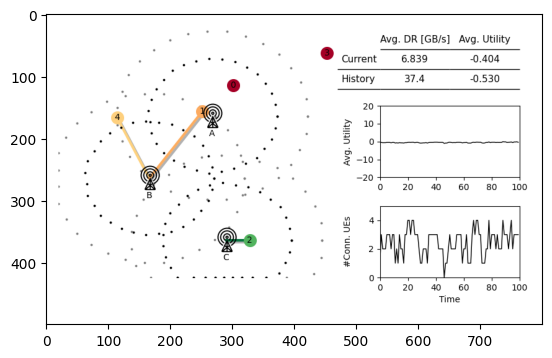

In [7]:
import mobile_env
import matplotlib.pyplot as plt
from IPython import display

# create the env for testing
# pass rgb_array as render mode so the env can be rendered inside the notebook
env = gymnasium.make(env_name, render_mode="rgb_array")
obs, info = env.reset()
done = False

# run one episode with the trained model
while not done:
    # gather action from each actor (for each UE)
    action = {}
    for agent_id, agent_obs in obs.items():
        # compute the action for the given agent using the shared policy
        action[agent_id] = ppo.compute_single_action(agent_obs, policy_id="shared_policy")

    # apply actions and perform step on simulation environment
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # render environment as RGB
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

While the learned policy is not yet perfect (the reward is still increasing, i.e., agent is still learning), the visualization shows that most users are connected to suitable cells.

Feel free to experiment more with `mobile-env`, e.g., by training longer or customizing the environment.
The [documentation](https://mobile-env.readthedocs.io/en/latest/) provides further information about the API.
If you still have open questions or run into issues, you can [open an issue on GitHub](https://github.com/stefanbschneider/mobile-env/issues).

We hope `mobile-env` is useful for you. If you use `mobile-env`, please cite it and let us know - then we can list your work on `mobile-env`'s Readme.
We also very much appreciate contributions in the form of pull requests.

```
@inproceedings{schneider2022mobileenv,
  author = {Schneider, Stefan and Werner, Stefan and Khalili, Ramin and Hecker, Artur and Karl, Holger},
  title = {mobile-env: An Open Platform for Reinforcement Learning in Wireless Mobile Networks},
  booktitle={Network Operations and Management Symposium (NOMS)},
  year = {2022},
  publisher = {IEEE/IFIP},
}
```

Happy training/learning!